# ECSE 415: Final Project
Mathieu Geoffroy, 260986559
Ryan Reszetnik, 260948454


December 5th, 2023

In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

working_dir = os.path.curdir

In [69]:
# load videos
video_mcgill = cv2.VideoCapture(os.path.join(working_dir, 'mcgill_drive.mp4'))
video_stcat = cv2.VideoCapture(os.path.join(working_dir, 'st-catherines_drive.mp4'))

In [70]:
#print the number of frames in each video
print("Number of frames in McGill video: ", int(video_mcgill.get(cv2.CAP_PROP_FRAME_COUNT)))
print("Number of frames in St-Catherine video: ", int(video_stcat.get(cv2.CAP_PROP_FRAME_COUNT)))

Number of frames in McGill video:  1071
Number of frames in St-Catherine video:  1477


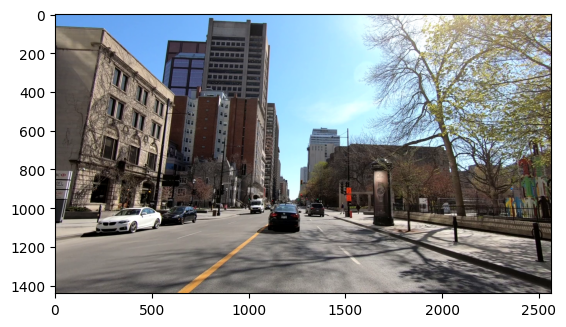

In [71]:
first_frame_mcgill = video_mcgill.read()[1]
for i in range(10):
    video_mcgill.read()
second_frame_mcgill = video_mcgill.read()[1]

plt.imshow(first_frame_mcgill[:,:,::-1])
plt.show()

In [72]:
import torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)
model.eval()

/Users/rreszetnik/Desktop/ECSE_415/ECSE415Project/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rreszetnik/Desktop/ECSE_415/ECSE415Project/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [73]:
class_names = torchvision.models.detection.faster_rcnn._COCO_CATEGORIES
PERSON_CLASS_ID = 1
CAR_CLASS_ID = 3
# model.to('mps')
def get_predictions(img):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    transformed_img = transform(img).unsqueeze(0)
    # transofrmed_img = transformed_img.to('mps')
    predictions = model(transformed_img)
    people_predictions = []
    cars_predictions = []
    for i in range(len(predictions[0]['labels'])):
        if predictions[0]['labels'][i] == PERSON_CLASS_ID:
            people_predictions.append(predictions[0]['masks'][i].detach().numpy())
        elif predictions[0]['labels'][i] == CAR_CLASS_ID:
            cars_predictions.append(predictions[0]['masks'][i].detach().numpy())
    return people_predictions, cars_predictions

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# transformed_street_img = transform(first_frame_mcgill).unsqueeze(0)
# predictions = model(transformed_street_img)


In [74]:
people_predictions, cars_predictions = get_predictions(first_frame_mcgill)


Number of people masks:  11 
Number of cars masks:  21


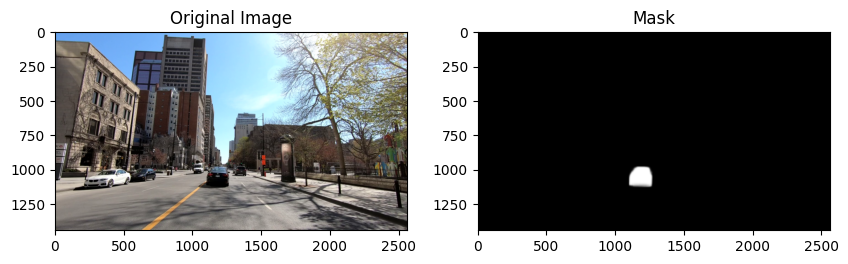

In [90]:
#plot the masks
print('Number of people masks: ', len(people_predictions)
        , '\nNumber of cars masks: ', len(cars_predictions))
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(first_frame_mcgill[:,:,::-1])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(cars_predictions[0][0,:,:],cmap='gray')
plt.title('Mask')
plt.show()

Shape of flow:  [-4.2349295e-13 -6.8506713e-13]


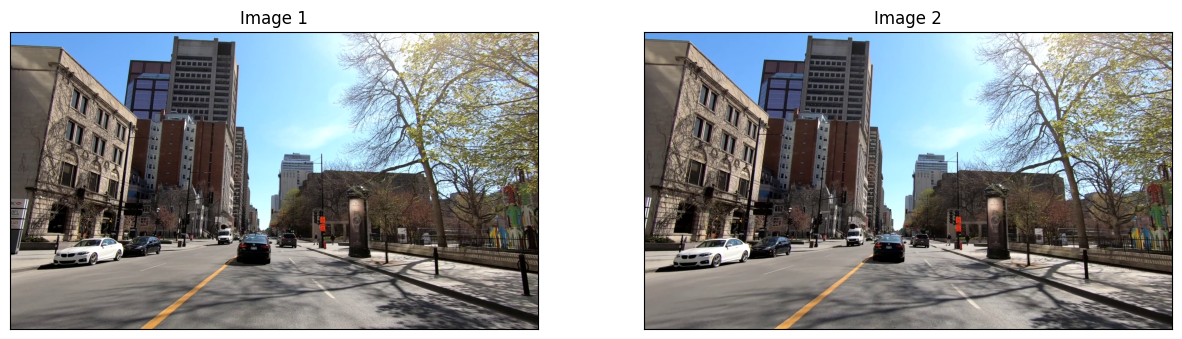

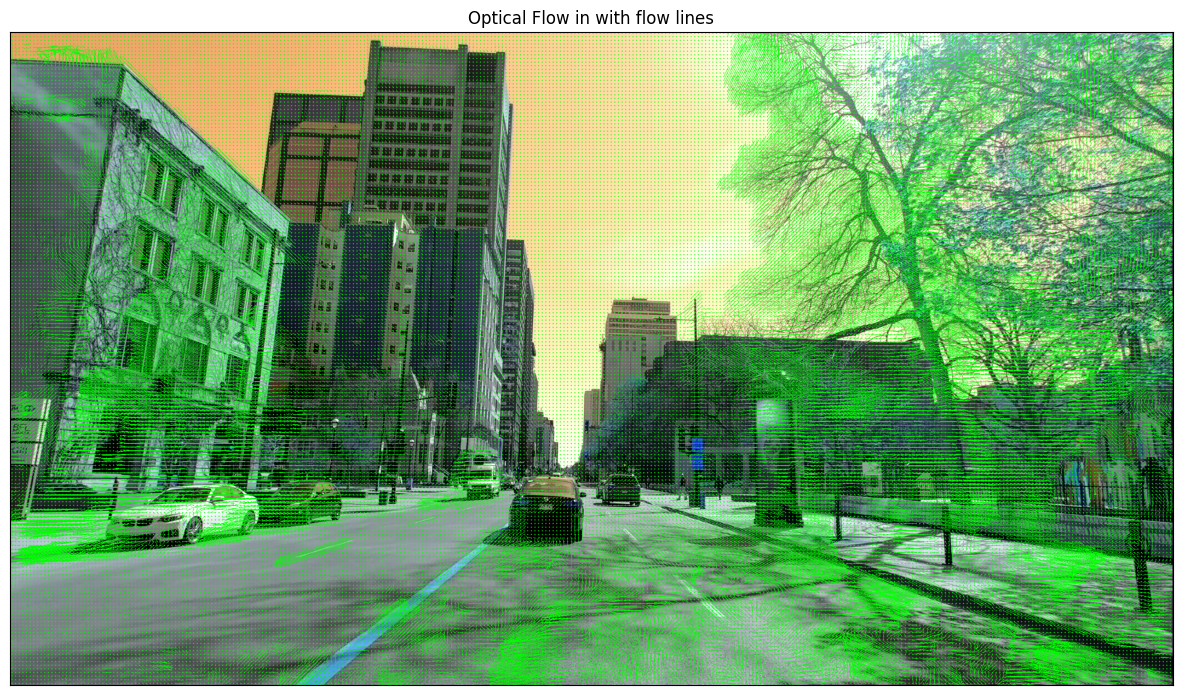

In [98]:
# A function to help draw optical flow with flow lines
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = img.copy()#cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

# read images
img1 = first_frame_mcgill
img2 = second_frame_mcgill

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Compute optical flow using the Gunner Farneback's algorithm
# Parameters
#          prev	first 8-bit single-channel input image.
#          next	second input image of the same size and the same type as prev.
#          flow	computed flow image that has the same size as prev and type CV_32FC2.
#          pyr_scale	parameter, specifying the image scale (<1) to build pyramids for each image; 
#                       pyr_scale=0.5 means a classical pyramid, where each next layer is twice smaller than the previous one.
#          levels	number of pyramid layers including the initial image; 
#                   levels=1 means that no extra layers are created and only the original images are used.
#          winsize	averaging window size; larger values increase the algorithm robustness to image noise 
#                   and give more chances for fast motion detection, but yield more blurred motion field.
#          iterations	number of iterations the algorithm does at each pyramid level.
#          poly_n	size of the pixel neighborhood used to find polynomial expansion in each pixel; 
#                   larger values mean that the image will be approximated with smoother surfaces, 
#                   yielding more robust algorithm and more blurred motion field, typically poly_n =5 or 7.
#          poly_sigma	standard deviation of the Gaussian that is used to smooth derivatives used as a basis 
#                       for the polynomial expansion; for poly_n=5, you can set poly_sigma=1.1, 
#                                                     for poly_n=7, a good value would be poly_sigma=1.5.
#          flags	operation flags that can be a combination of the following:
#                   OPTFLOW_USE_INITIAL_FLOW uses the input flow as an initial flow approximation.
#                   OPTFLOW_FARNEBACK_GAUSSIAN uses the Gaussian winsize×winsize filter instead of 
#                                              a box filter of the same size for optical flow estimation; 
#                                              usually, this option gives z more accurate flow than with a box filter, 
#                                              at the cost of lower speed; 
#                                              normally, winsize for a Gaussian window should be set to a larger 
#                                              value to achieve the same level of robustness.

def calc_flow(img1,img2):
    return cv2.calcOpticalFlowFarneback(prev=img1, 
                                    next=img2, 
                                    flow=None,
                                    pyr_scale=0.5, 
                                    levels=3, 
                                    winsize=15,
                                    iterations=3, 
                                    poly_n=5, 
                                    poly_sigma=1.2, 
                                    flags=0)
def calc_all_flows(video):
    ret, prev_frame = video.read()
    prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    flows = []
    while(video.isOpened()):
        ret, next_frame = video.read()
        if ret == True:
            next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
            flows.append(calc_flow(prev_frame, next_frame))
            prev_frame = next_frame
        else:
            break
    return flows
all_flows = calc_all_flows(video_mcgill)
flow = calc_flow(img1_gray, img2_gray)

# draw flow
vis = draw_flow(img1, flow, step=8)

print("Shape of flow: ", flow[0][0])    

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.imshow(vis)
plt.title("Optical Flow in with flow lines"), plt.xticks([]), plt.yticks([])
plt.show()

Centroid of the mask:  (1055.6765503080082, 1183.0686242299794)


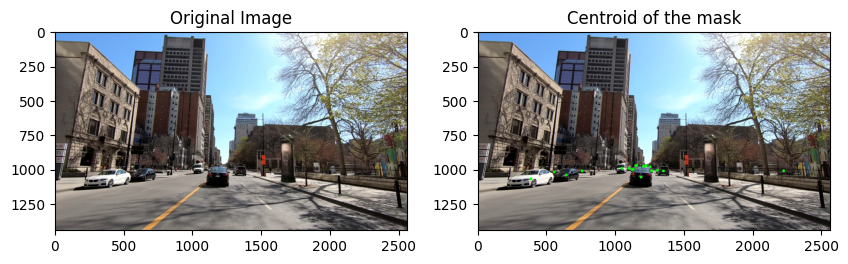

In [117]:
#plot the centroids of the masks
def get_centroid(mask):
    x = np.where(mask>0.1)[0]
    y = np.where(mask>0.1)[1]
    return np.mean(x), np.mean(y)
def draw_point(img, point):
    img = img.copy()
    cv2.circle(img, (int(point[1]), int(point[0])), 10, (0,255,0), -1)
    return img
def draw_points(img, points):
    img = img.copy()
    for point in points:
        img = draw_point(img, point)
    return img

car_centroids = [
    get_centroid(car[0]) for car in cars_predictions
]
centroid = get_centroid(cars_predictions[0][0])
print("Centroid of the mask: ", centroid)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(first_frame_mcgill[:,:,::-1])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(draw_points(first_frame_mcgill, car_centroids)[:,:,::-1])
plt.title('Centroid of the mask')
plt.show()

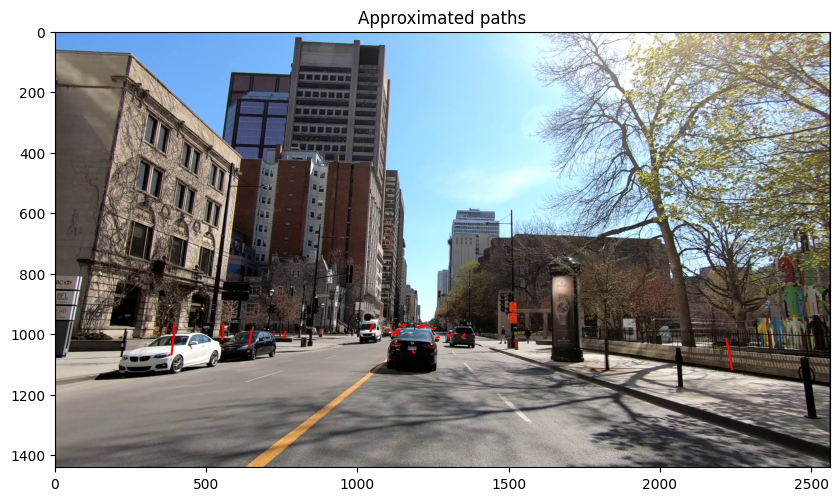

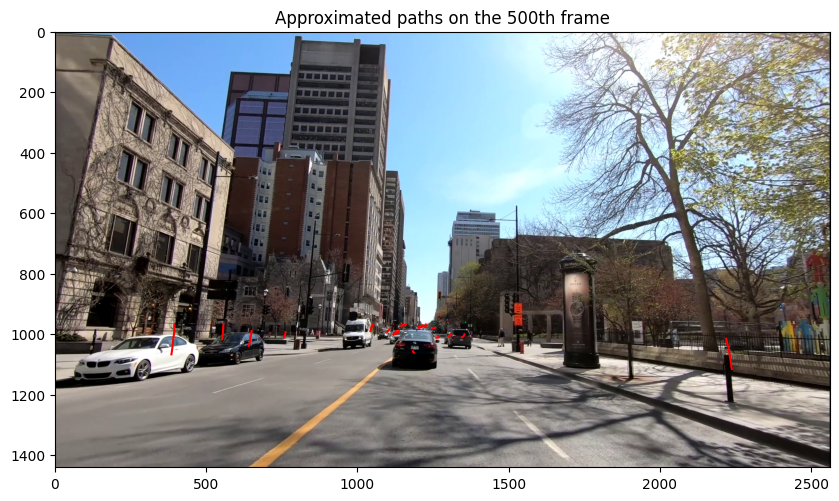

In [116]:
def calc_approx_over_time(flows,point):
    approx = []
    for flow in flows:
        avg_flow = np.mean(flow[int(point[0])-10:int(point[0])+10,int(point[1])-10:int(point[1])+10], axis=(0,1))
        new_point = point+avg_flow
        #cap the point to be in the image size
        new_point[0] = max(0,min(new_point[0], flow.shape[0]-1))
        new_point[1] = max(0,min(new_point[1], flow.shape[1]-1))
        approx.append(new_point)
        point = new_point
    return np.array(approx)

all_centroids = []
for mask in cars_predictions:
    all_centroids.append(get_centroid(mask[0]))

all_paths = []
for centroid in all_centroids:
    all_paths.append(calc_approx_over_time(all_flows[:20], centroid))

#plot the approximated paths
plt.figure(figsize=(10,10))
plt.imshow(first_frame_mcgill[:,:,::-1])
for path in all_paths:
    plt.plot(path[:,1], path[:,0], 'r')
plt.title('Approximated paths')
plt.show()

#show the approximated paths on the 500th frame

new_mcgill_video = cv2.VideoCapture(os.path.join(working_dir, 'mcgill_drive.mp4'))
for i in range(20):
    new_mcgill_video.read()

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(new_mcgill_video.read()[1], cv2.COLOR_BGR2RGB))
for path in all_paths:
    plt.plot(path[:,1], path[:,0], 'r')
plt.title('Approximated paths on the 500th frame')
plt.show()


In [128]:
import cv2
#create kfc tracker
tracker = cv2.TrackerKCF_create()

AttributeError: module 'cv2' has no attribute 'TrackerKCF_create'